# Inverse of ene_dependent Gaussian

Simulate a double gaussian and fit back with PWNGaussian

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
from pathlib import Path
import numpy as np
from astropy import units as u
from astropy.coordinates import SkyCoord, Angle
from astropy.coordinates.angle_utilities import angular_separation, position_angle
from regions import CircleSkyRegion, RectangleSkyRegion
from gammapy.data import DataStore, Observation
from gammapy.maps import WcsGeom, MapAxis, Map
from gammapy.makers import (
    MapDatasetMaker,  
    SafeMaskMaker, 
    FoVBackgroundMaker
)
from gammapy.datasets import MapDataset
from gammapy.modeling.models import (
    SkyModel,
    PowerLawSpectralModel,
    PowerLaw2SpectralModel,
    PointSpatialModel,
    SpatialModel,
    FoVBackgroundModel,
    Models,
    GaussianSpatialModel
)
from gammapy.estimators import FluxPointsEstimator
from gammapy.modeling import Parameter, Parameters, Fit
from astropy.coordinates.angle_utilities import angular_separation
import scipy.stats
from gammapy.estimators import ExcessMapEstimator

In [2]:
def plot_hist(sig_map, ax, label="", color="blue"):
    sig = sig_map.data.ravel()
    ax.hist(
        sig,
        density=True,
        alpha=0.5,
        color=color,
        bins=100,
    )
    ax.set_title(label)
    mu, std = scipy.stats.norm.fit(sig)
    x = np.linspace(-8, 8, 50)
    p = scipy.stats.norm.pdf(x, mu, std)
    ax.plot(x, p, lw=2, color=color)
    ax.legend()
    ax.set_xlabel("Significance")
    ax.set_xlim(-5,5)
    ax.set_yscale("log")
    ax.set_ylim(1e-3, 1)
    
    ax.text(2,0.5, f"mu = {mu:.2f}")
    ax.text(2,0.3, f"std = {std:.2f}")

    print(f" {label}: mu = {mu:.2f}, std = {std:.2f}")
    
    p = scipy.stats.norm.pdf(x, 0, 1)
    plt.plot(x, p, lw=2, color="black")

In [3]:
class PWNGaussianModel(SpatialModel):
    """My custom Energy Dependent Gaussian model.

    Parameters
    ----------
    lon_0, lat_0 : `~astropy.coordinates.Angle`
        Center position
    sigma_1TeV : `~astropy.coordinates.Angle`
        Width of the Gaussian at 1 TeV
    sigma_10TeV : `~astropy.coordinates.Angle`
        Width of the Gaussian at 10 TeV

    """

    tag = "PWNGaussianModel"
    lon_0 = Parameter("lon_0", "0 deg")
    lat_0 = Parameter("lat_0", "0 deg", min=-90, max=90)
    alpha = Parameter("alpha", 1.0) #energy dependence of sigma
    ref = Parameter("ref", "1 TeV", frozen=True)
    sigma_ref = Parameter("sigma_ref", "1.0 deg", min=0) #sigma at reference value
    
    is_energy_dependent = True
    

    @staticmethod
    def get_sigma(energy, alpha, ref, sigma_ref):
        """Get the sigma for a particular energy"""
        sigma = sigma_ref * np.power(energy/ref, -alpha)
        return sigma

    def evaluate(
        self, lon, lat, energy, lon_0, lat_0, alpha, ref, sigma_ref,
    ):
        """Evaluate custom Gaussian model"""

        sigma = self.get_sigma(energy, alpha.value, ref, sigma_ref)
        sep = angular_separation(lon, lat, lon_0, lat_0)

        exponent = -0.5 * (sep / sigma) ** 2
        norm = 1 / (2 * np.pi * sigma ** 2)
        return norm * np.exp(exponent)

    @property
    def evaluation_radius(self):
        """Evaluation radius (`~astropy.coordinates.Angle`)."""
        return 5.0 * self.sigma_ref.quantity

## Simulations

In [4]:
data_store = DataStore.from_dir("$GAMMAPY_DATA/hess-dl3-dr1")
obs = data_store.obs(20137)
irfs = {'aeff': obs.aeff,
        'edisp': obs.edisp,
        'psf': obs.psf,
        'bkg': obs.bkg}

In [5]:
# Define the observation parameters (typically the observation duration and the pointing position):
livetime = 20.0 * u.hr
pointing = SkyCoord(0, 0, unit="deg", frame="galactic")

In [6]:
# Define map geometry for binned simulation
energy_reco = MapAxis.from_edges(
    np.logspace(-0.1, 1.3, 10), unit="TeV", name="energy", interp="log"
)
geom = WcsGeom.create(
    skydir=(0, 0),
    binsz=0.01,
    width=(4, 4),
    frame="galactic",
    axes=[energy_reco],
)
# It is usually useful to have a separate binning for the true energy axis
energy_true = MapAxis.from_edges(
    np.logspace(-1.5, 1.5, 30), unit="TeV", name="energy", interp="log"
)
energy_reco.edges

<Quantity [ 0.79432823,  1.13646367,  1.62596469,  2.32630507,  3.32829814,
            4.76187266,  6.81292069,  9.74740226, 13.94583249, 19.95262315] TeV>

In [19]:
models_read = Models.read("./models_double_gauss")
bkg_model = FoVBackgroundModel(dataset_name="dataset-simu")
models = Models([models_read[1], models_read[2], bkg_model])
print(models)

Models

Component 0: SkyModel

  Name                      : model-fit2a
  Datasets names            : None
  Spectral model type       : PowerLawSpectralModel
  Spatial  model type       : GaussianSpatialModel
  Temporal model type       : 
  Parameters:
    index                   :   0.848              
    amplitude               :   5.99e-13  1 / (cm2 s TeV)
    reference    (frozen)   :   1.000  TeV         
    lon_0                   :  -0.001  deg         
    lat_0                   :  -0.007  deg         
    sigma                   :   0.100  deg         
    e            (frozen)   :   0.000              
    phi          (frozen)   :   0.000  deg         

Component 1: SkyModel

  Name                      : model-fit2b
  Datasets names            : None
  Spectral model type       : PowerLawSpectralModel
  Spatial  model type       : GaussianSpatialModel
  Temporal model type       : 
  Parameters:
    index                   :   2.179              
    amplitude        

In [20]:
# Create an in-memory observation
obs = Observation.create(pointing=pointing, livetime=livetime, irfs=irfs)
# Make the MapDataset
empty = MapDataset.create(geom, name="dataset-simu")
maker = MapDatasetMaker(selection=["exposure", "background", "psf", "edisp"])
maker_safe_mask = SafeMaskMaker(methods=["offset-max"], offset_max=4.0 * u.deg)
dataset = maker.run(empty, obs)
dataset = maker_safe_mask.run(dataset, obs)
dataset.models = models
dataset.fake()
print(dataset)

MapDataset
----------

  Name                            : dataset-simu 

  Total counts                    : 97508 
  Total background counts         : 94879.27
  Total excess counts             : 2628.73

  Predicted counts                : 97287.02
  Predicted background counts     : 94879.27
  Predicted excess counts         : 2407.75

  Exposure min                    : 9.25e+08 m2 s
  Exposure max                    : 3.70e+10 m2 s

  Number of total bins            : 1440000 
  Number of fit bins              : 1440000 

  Fit statistic type              : cash
  Fit statistic value (-2 log(L)) : 635631.37

  Number of models                : 3 
  Number of parameters            : 19
  Number of free parameters       : 11

  Component 0: SkyModel
  
    Name                      : model-fit2a
    Datasets names            : None
    Spectral model type       : PowerLawSpectralModel
    Spatial  model type       : GaussianSpatialModel
    Temporal model type       : 
    Paramete

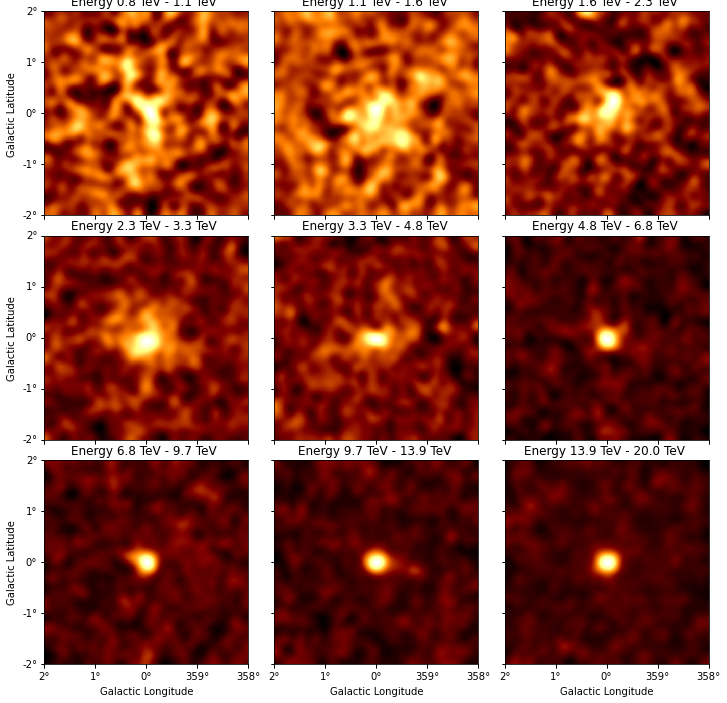

In [21]:
dataset.excess.smooth(0.1*u.deg).plot_grid();

In [22]:
estimator_ene = ExcessMapEstimator(correlation_radius=0.2*u.deg, 
                               energy_edges=energy_reco.edges,
                               selection_optional=None)

## Fit

### With energy dependent model

In [23]:
dataset1 = dataset.copy(name='dataset1')

In [24]:
region = CircleSkyRegion(center=geom.center_skydir,
                        radius=1.5*u.deg)

In [25]:
models = Models(dataset1.models['dataset1-bkg'])
dataset1.models = models

In [26]:
%%time
fit0 = Fit([dataset1]) #background only
result0 = fit0.run(optimize_opts={"print_level": 1})
L0 = dataset1.stat_sum()
AIC_0 = 2*len(result0.parameters.free_parameters.names) + result0.total_stat
print(result0.parameters.to_table())

------------------------------------------------------------------
| FCN = 6.372e+05               |      Ncalls=18 (18 total)      |
| EDM = 3.57e-05 (Goal: 0.0002) |            up = 1.0            |
------------------------------------------------------------------
|  Valid Min.   | Valid Param.  | Above EDM | Reached call limit |
------------------------------------------------------------------
|     True      |     True      |   False   |       False        |
------------------------------------------------------------------
| Hesse failed  |   Has cov.    | Accurate  | Pos. def. | Forced |
------------------------------------------------------------------
|     False     |     True      |   True    |   True    | False  |
------------------------------------------------------------------
   name     value    unit min max frozen   error  
--------- ---------- ---- --- --- ------ ---------
     norm 1.0277e+00      nan nan  False 3.291e-03
     tilt 0.0000e+00      nan nan   True 0.

In [27]:
fit_spatial = PWNGaussianModel(frame='galactic')
fit_spectal = PowerLawSpectralModel()
model_fit = SkyModel(spatial_model=fit_spatial,
                     spectral_model = fit_spectal, name='model_simu')
model_fit.parameters['lon_0'].value = 0.01
model_fit.parameters['lat_0'].value = 0.01
model_fit.parameters['amplitude'].value = 1.0e-11
model_fit.parameters['amplitude'].min = 0.0
model_fit.parameters['index'].value = 2.3
model_fit.parameters['index'].min = 0.0
model_fit.parameters['alpha'].value = 1.0
model_fit.parameters['alpha'].max = 2.0

models.append(model_fit)
dataset1.models = models
print(dataset1)

MapDataset
----------

  Name                            : dataset1 

  Total counts                    : 97508 
  Total background counts         : 94879.27
  Total excess counts             : 2628.73

  Predicted counts                : 99532.21
  Predicted background counts     : 97506.14
  Predicted excess counts         : 2026.07

  Exposure min                    : 9.25e+08 m2 s
  Exposure max                    : 3.70e+10 m2 s

  Number of total bins            : 1440000 
  Number of fit bins              : 1440000 

  Fit statistic type              : cash
  Fit statistic value (-2 log(L)) : 635958.03

  Number of models                : 2 
  Number of parameters            : 11
  Number of free parameters       : 7

  Component 0: FoVBackgroundModel
  
    Name                      : dataset1-bkg
    Datasets names            : ['dataset1']
    Spectral model type       : PowerLawNormSpectralModel
    Parameters:
      norm                    :   1.028              
      tilt

In [28]:
%%time
fit1 = Fit([dataset1])
result1 = fit1.run(optimize_opts={"print_level": 1})

------------------------------------------------------------------
| FCN = 6.357e+05               |     Ncalls=617 (617 total)     |
| EDM = 0.00602 (Goal: 0.0002)  |            up = 1.0            |
------------------------------------------------------------------
|  Valid Min.   | Valid Param.  | Above EDM | Reached call limit |
------------------------------------------------------------------
|     False     |     True      |   True    |       False        |
------------------------------------------------------------------
| Hesse failed  |   Has cov.    | Accurate  | Pos. def. | Forced |
------------------------------------------------------------------
|     False     |     True      |   True    |   True    | False  |
------------------------------------------------------------------
CPU times: user 1min 7s, sys: 6.42 s, total: 1min 13s
Wall time: 1min 13s


In [29]:
L1 = result1.total_stat

In [30]:
print(L0-L1)
AIC_1 = 2*len(result1.parameters.free_parameters.names) + L1

1529.803574756137


In [31]:
print(dataset1.models.parameters.to_table())

   name      value         unit         min        max    frozen   error  
--------- ----------- -------------- ---------- --------- ------ ---------
     norm  1.0077e+00                       nan       nan  False 3.631e-03
     tilt  0.0000e+00                       nan       nan   True 0.000e+00
reference  1.0000e+00            TeV        nan       nan   True 0.000e+00
    index  1.6244e+00                 0.000e+00       nan  False 7.892e-02
amplitude  4.4840e-12 cm-2 s-1 TeV-1  0.000e+00       nan  False 7.463e-13
reference  1.0000e+00            TeV        nan       nan   True 0.000e+00
    lon_0 -1.1280e-02            deg        nan       nan  False 7.360e-03
    lat_0 -6.4214e-03            deg -9.000e+01 9.000e+01  False 7.066e-03
    alpha  5.5106e-01                       nan 2.000e+00  False 5.730e-02
      ref  1.0000e+00            TeV        nan       nan   True 0.000e+00
sigma_ref  4.1472e-01            deg  0.000e+00       nan  False 5.192e-02


/Users/asinha/Gammapy-dev/gammapy/gammapy/maps/wcsnd.py:400: MatplotlibDeprecationWarning: Passing parameters norm and vmin/vmax simultaneously is deprecated since 3.3 and will become an error two minor releases later. Please pass vmin/vmax directly to the norm when creating it.
  im = ax.imshow(data, **kwargs)


<AxesSubplot:xlabel='Energy [TeV]', ylabel='Residuals (data - model)'>

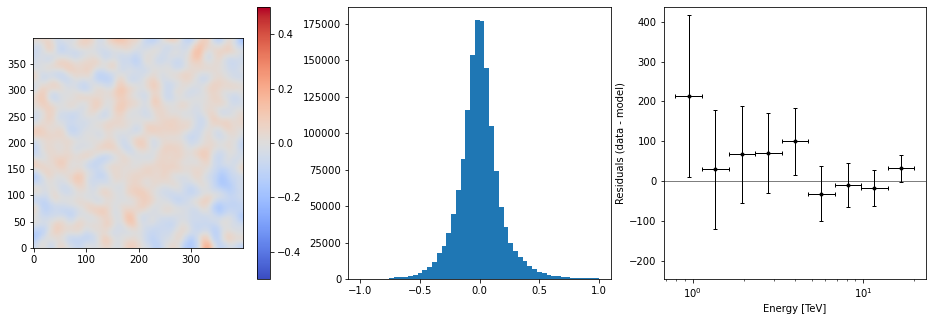

In [33]:
plt.figure(figsize=(16,5))

ax1 = plt.subplot(131)
dataset1.plot_residuals_spatial(method="diff/model", 
                                vmin=-0.5, vmax=0.5,
                               ax = ax1)

ax2 = plt.subplot(132)
ax2.hist(dataset1.residuals(method='diff/model', width=0.1*u.deg).data.ravel(), 
         bins=50, range=[-1,1]);

ax3 = plt.subplot(133)
dataset1.plot_residuals_spectral(region=region)

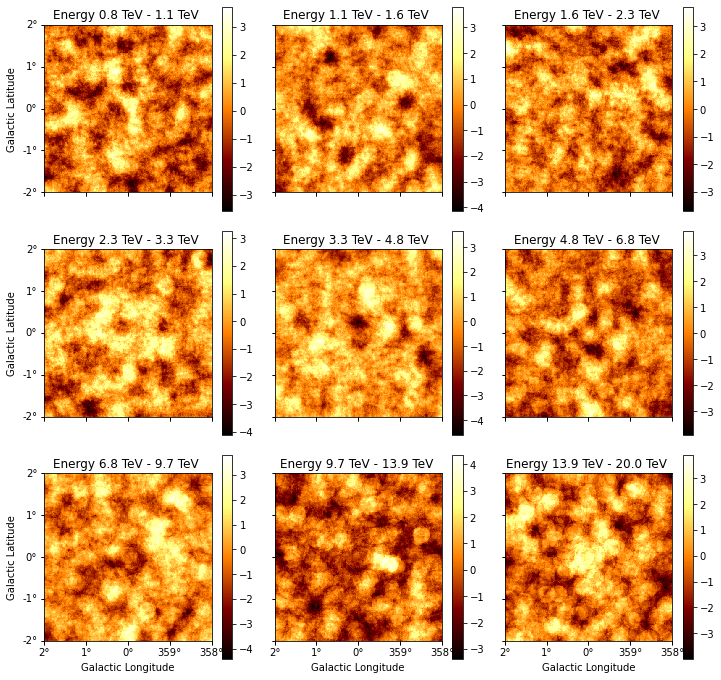

In [34]:
residual1 = estimator_ene.run(dataset1)
residual1['sqrt_ts'].plot_grid(add_cbar=True);

## Now, as a sum of two Gaussians

In [35]:
dataset2 = dataset.copy(name='dataset2')

In [36]:
models2 = Models(dataset2.models['dataset2-bkg'])
dataset2.models = models2

In [37]:
spatial_model2a = GaussianSpatialModel(
    lon_0="0.0 deg", lat_0="0.0 deg", sigma="0.5 deg", frame="galactic"
)
spectral_model2a = PowerLawSpectralModel()
model_fit2a = SkyModel(
    spatial_model=spatial_model2a,
    spectral_model=spectral_model2a,
    name="model-fit2a",
)
model_fit2a.parameters['lon_0'].value = 0.1
model_fit2a.parameters['lat_0'].value = 0.1
model_fit2a.parameters['amplitude'].value = 1.0e-11
model_fit2a.parameters['amplitude'].min = 0.0
model_fit2a.parameters['index'].value = 2.3
model_fit2a.parameters['index'].min = 0.0
model_fit2a.parameters['sigma'].value = 1.0

models2.append(model_fit2a)
dataset2.models = models2
print(dataset2)

MapDataset
----------

  Name                            : dataset2 

  Total counts                    : 97508 
  Total background counts         : 94879.27
  Total excess counts             : 2628.73

  Predicted counts                : 96512.52
  Predicted background counts     : 94879.27
  Predicted excess counts         : 1633.25

  Exposure min                    : 9.25e+08 m2 s
  Exposure max                    : 3.70e+10 m2 s

  Number of total bins            : 1440000 
  Number of fit bins              : 1440000 

  Fit statistic type              : cash
  Fit statistic value (-2 log(L)) : 637039.27

  Number of models                : 2 
  Number of parameters            : 11
  Number of free parameters       : 6

  Component 0: FoVBackgroundModel
  
    Name                      : dataset2-bkg
    Datasets names            : ['dataset2']
    Spectral model type       : PowerLawNormSpectralModel
    Parameters:
      norm                    :   1.000              
      tilt

In [38]:
%%time
fit3 = Fit([dataset2])
result3 = fit3.run(optimize_opts={"print_level": 1})

------------------------------------------------------------------
| FCN = 6.357e+05               |     Ncalls=380 (380 total)     |
| EDM = 5.03e-05 (Goal: 0.0002) |            up = 1.0            |
------------------------------------------------------------------
|  Valid Min.   | Valid Param.  | Above EDM | Reached call limit |
------------------------------------------------------------------
|     True      |     True      |   False   |       False        |
------------------------------------------------------------------
| Hesse failed  |   Has cov.    | Accurate  | Pos. def. | Forced |
------------------------------------------------------------------
|     False     |     True      |   True    |   True    | False  |
------------------------------------------------------------------
CPU times: user 18.6 s, sys: 2.62 s, total: 21.2 s
Wall time: 21.3 s


In [39]:
L3 = result3.total_stat

In [40]:
print(L0-L3)
AIC_3 = 2*len(result3.parameters.free_parameters.names) + L3

1485.263390783919


/Users/asinha/Gammapy-dev/gammapy/gammapy/maps/wcsnd.py:400: MatplotlibDeprecationWarning: Passing parameters norm and vmin/vmax simultaneously is deprecated since 3.3 and will become an error two minor releases later. Please pass vmin/vmax directly to the norm when creating it.
  im = ax.imshow(data, **kwargs)


<AxesSubplot:xlabel='Energy [TeV]', ylabel='Residuals (data - model)'>

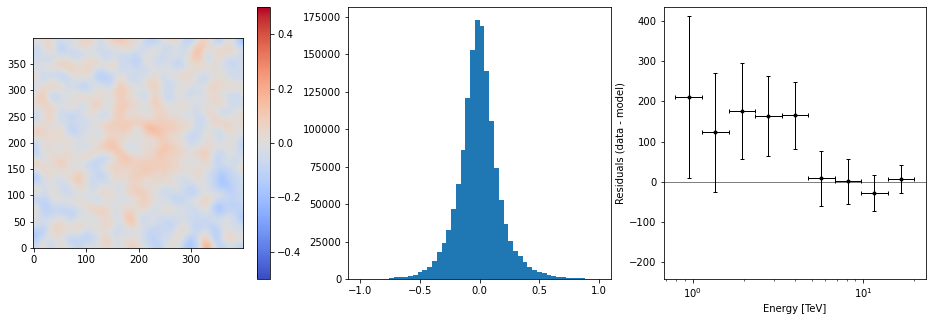

In [41]:
plt.figure(figsize=(16,5))

ax1 = plt.subplot(131)
dataset2.plot_residuals_spatial(method="diff/model", 
                                vmin=-0.5, vmax=0.5,
                               ax = ax1)

ax2 = plt.subplot(132)
ax2.hist(dataset2.residuals(method='diff/model', width=0.1*u.deg).data.ravel(), 
         bins=50, range=[-1,1]);


ax3 = plt.subplot(133)
dataset2.plot_residuals_spectral(region=region)

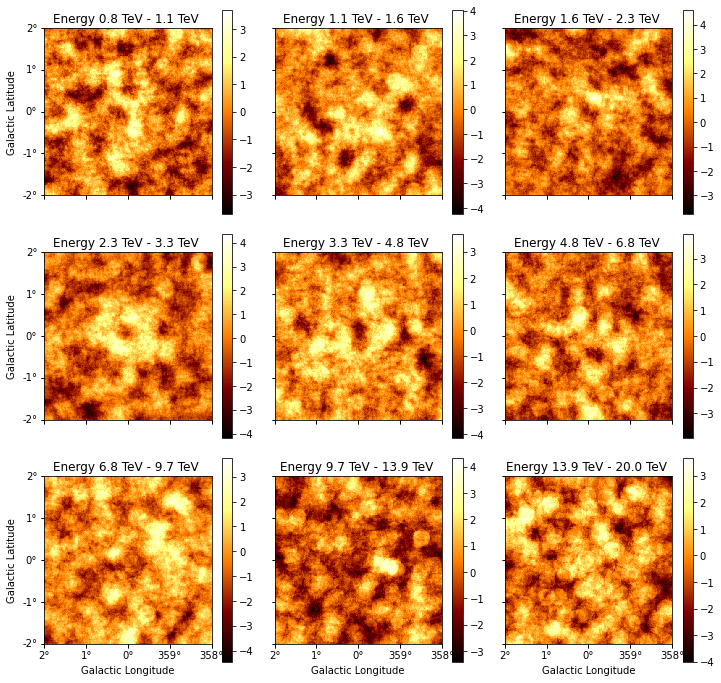

In [42]:
residual3 = estimator_ene.run(dataset2)
residual3['sqrt_ts'].plot_grid(add_cbar=True);

In [43]:
result3.parameters.to_table()

name,value,unit,min,max,frozen,error
str9,float64,str14,float64,float64,bool,float64
norm,1.0162e+00,,nan,nan,False,3.326e-03
tilt,0.0000e+00,,nan,nan,True,0.000e+00
reference,1.0000e+00,TeV,nan,nan,True,0.000e+00
index,1.0820e+00,,0.000e+00,nan,False,6.545e-02
amplitude,1.2862e-12,cm-2 s-1 TeV-1,0.000e+00,nan,False,1.807e-13
reference,1.0000e+00,TeV,nan,nan,True,0.000e+00
lon_0,-1.2364e-02,deg,nan,nan,False,7.081e-03
lat_0,-8.9234e-03,deg,-9.000e+01,9.000e+01,False,6.831e-03
sigma,1.1352e-01,deg,0.000e+00,nan,False,5.868e-03


Add second gaussian

In [44]:
spatial_model2b = GaussianSpatialModel(
    lon_0="0.0 deg", lat_0="0.0 deg", sigma="0.5 deg", frame="galactic"
)
spectral_model2b = PowerLawSpectralModel()
model_fit2b = SkyModel(
    spatial_model=spatial_model2b,
    spectral_model=spectral_model2b,
    name="model-fit2b",
)
model_fit2b.parameters['lon_0'].value = 0.1
model_fit2b.parameters['lat_0'].value = 0.1
model_fit2b.parameters['amplitude'].value = 1.0e-12
model_fit2b.parameters['amplitude'].min = 0.0
model_fit2b.parameters['index'].value = 2.3
model_fit2b.parameters['index'].min = 0.0
model_fit2b.parameters['sigma'].value = 1.0

models2.append(model_fit2b)
dataset2.models = models2
print(dataset2)

MapDataset
----------

  Name                            : dataset2 

  Total counts                    : 97508 
  Total background counts         : 94879.27
  Total excess counts             : 2628.73

  Predicted counts                : 97686.60
  Predicted background counts     : 96414.23
  Predicted excess counts         : 1272.37

  Exposure min                    : 9.25e+08 m2 s
  Exposure max                    : 3.70e+10 m2 s

  Number of total bins            : 1440000 
  Number of fit bins              : 1440000 

  Fit statistic type              : cash
  Fit statistic value (-2 log(L)) : 635731.70

  Number of models                : 3 
  Number of parameters            : 19
  Number of free parameters       : 11

  Component 0: FoVBackgroundModel
  
    Name                      : dataset2-bkg
    Datasets names            : ['dataset2']
    Spectral model type       : PowerLawNormSpectralModel
    Parameters:
      norm                    :   1.016              
      til

In [45]:
%%time
fit4 = Fit([dataset2])
result4 = fit4.run(optimize_opts={"print_level": 1})

------------------------------------------------------------------
| FCN = 6.356e+05               |     Ncalls=659 (659 total)     |
| EDM = 0.000238 (Goal: 0.0002) |            up = 1.0            |
------------------------------------------------------------------
|  Valid Min.   | Valid Param.  | Above EDM | Reached call limit |
------------------------------------------------------------------
|     True      |     True      |   False   |       False        |
------------------------------------------------------------------
| Hesse failed  |   Has cov.    | Accurate  | Pos. def. | Forced |
------------------------------------------------------------------
|     False     |     True      |   True    |   True    | False  |
------------------------------------------------------------------
CPU times: user 1min, sys: 7.78 s, total: 1min 8s
Wall time: 1min 8s


In [46]:
L4 = result4.total_stat
AIC_4 = 2*len(result4.parameters.free_parameters.names) + L4

In [47]:
print(L3-L4)

119.69627668499015


In [48]:
result4.parameters.to_table()

name,value,unit,min,max,frozen,error
str9,float64,str14,float64,float64,bool,float64
norm,9.9860e-01,,nan,nan,False,4.076e-03
tilt,0.0000e+00,,nan,nan,True,0.000e+00
reference,1.0000e+00,TeV,nan,nan,True,0.000e+00
index,7.3043e-01,,0.000e+00,nan,False,9.711e-02
amplitude,4.6629e-13,cm-2 s-1 TeV-1,0.000e+00,nan,False,1.072e-13
reference,1.0000e+00,TeV,nan,nan,True,0.000e+00
lon_0,-9.6780e-03,deg,nan,nan,False,7.119e-03
lat_0,-1.0284e-02,deg,-9.000e+01,9.000e+01,False,6.749e-03
sigma,9.4134e-02,deg,0.000e+00,nan,False,5.026e-03


/Users/asinha/Gammapy-dev/gammapy/gammapy/maps/wcsnd.py:400: MatplotlibDeprecationWarning: Passing parameters norm and vmin/vmax simultaneously is deprecated since 3.3 and will become an error two minor releases later. Please pass vmin/vmax directly to the norm when creating it.
  im = ax.imshow(data, **kwargs)


<AxesSubplot:xlabel='Energy [TeV]', ylabel='Residuals (data - model)'>

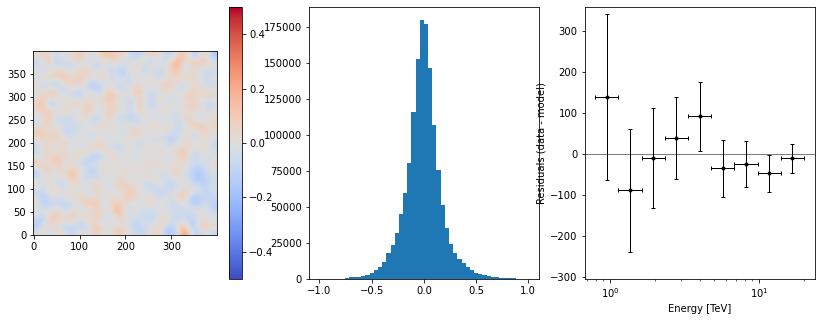

In [49]:
plt.figure(figsize=(14,5))

ax1 = plt.subplot(131)
dataset2.plot_residuals_spatial(method="diff/model", 
                                vmin=-0.5, vmax=0.5,
                               ax = ax1)

ax2 = plt.subplot(132)
ax2.hist(dataset2.residuals(method='diff/model', width=0.1*u.deg).data.ravel(), 
         bins=50, range=[-1,1]);

ax3 = plt.subplot(133)
dataset2.plot_residuals_spectral(region=region)

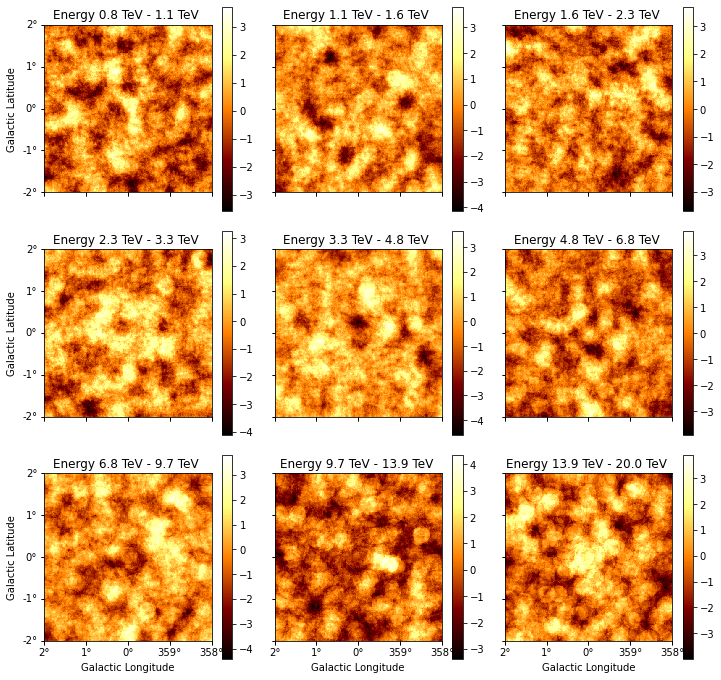

In [50]:
residual4 = estimator_ene.run(dataset1)
residual4['sqrt_ts'].plot_grid(add_cbar=True);

## Differention using visual inspection

Text(0.5, 1.0, 'residual distribution')

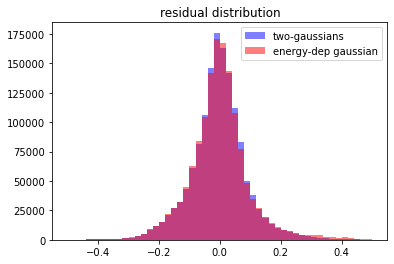

In [51]:
plt.hist(dataset2.residuals(method='diff/model', width=0.2*u.deg).data.ravel(), 
         bins=50, range=[-0.5,0.5], alpha=0.5, label='two-gaussians', color='blue');
plt.hist(dataset1.residuals(method='diff/model', width=0.2*u.deg).data.ravel(), 
         bins=50, range=[-0.5,0.5], alpha=0.5, label='energy-dep gaussian', 
        color='red');
plt.legend()
plt.title('residual distribution')

No handles with labels found to put in legend.
No handles with labels found to put in legend.


 : mu = -0.03, std = 1.03
 : mu = -0.01, std = 1.00


Text(0.5, 1.0, 'significance')

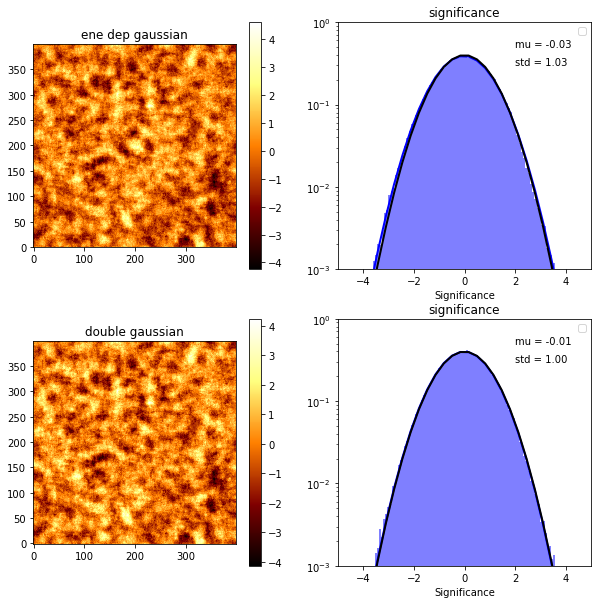

In [52]:
estimator = ExcessMapEstimator(correlation_radius=0.1*u.deg,
                               selection_optional=None)
residual5 = estimator.run(dataset1)
residual6 = estimator.run(dataset2)

plt.figure(figsize=(10,10))

ax1 = plt.subplot(221)
residual5['sqrt_ts'].plot(ax=ax1, add_cbar=True);
ax1.set_title('ene dep gaussian')

ax2 = plt.subplot(222)
plot_hist(residual5['sqrt_ts'], ax2);
ax2.set_title('significance')

ax3 = plt.subplot(223)
residual6['sqrt_ts'].plot(ax=ax3, add_cbar=True);
ax3.set_title('double gaussian')

ax4 = plt.subplot(224)
plot_hist(residual6['sqrt_ts'], ax4);
ax4.set_title('significance')




Text(0.5, 1.0, 'double gaussian')

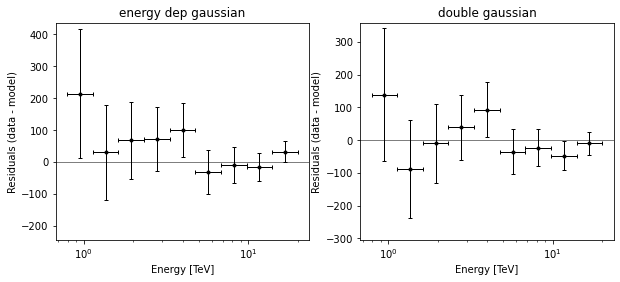

In [53]:
plt.figure(figsize=(10,4))

ax1 = plt.subplot(121)
dataset1.plot_residuals_spectral(region=region, ax=ax1,)
ax1.set_title('energy dep gaussian')

ax2 = plt.subplot(122)
dataset2.plot_residuals_spectral(region=region, ax=ax2,)
ax2.set_title('double gaussian')

### Using AIC

In [56]:
from scipy.stats import chi2
print('Significance of energy dep gaussian: ', (L0-L1), 'p-value:' ,(chi2.sf(L0-L1,5)))

Significance of energy dep gaussian:  1529.803574756137 p-value: 0.0


In [57]:
print('Significance of first gaussian: ', (L0-L3), 'p-value:' ,(chi2.sf(L0-L3,5)))
print('Significance of second gaussian: ', (L3-L4), 'p-value:' ,(chi2.sf(L3-L4,5)))

Significance of first gaussian:  1485.263390783919 p-value: 0.0
Significance of second gaussian:  119.69627668499015 p-value: 3.639672095519812e-24


In [58]:
L0-L4, L0-L1

(1604.9596674689092, 1529.803574756137)

The double gaussian has a higher delta TS in this case. Because it also has more free parameters, the AIC is a useful discriminant is this case

In [60]:
L_AIC = np.exp((+AIC_4 - AIC_1)/2.0)
print(AIC_4 - AIC_1, L_AIC)

-67.15609271277208 2.6136038085927643e-15


In this case, it correctly reproduces the underlying 2-source morphology as well :)